<a href="https://colab.research.google.com/github/funghostvn/datascience/blob/master/VNDSFAChart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
from bs4 import BeautifulSoup
import json 
import pandas as pd 
import numpy as np

symbol = 'UIC'
year = ['2019','2018','2017','2015','2014']
quarter = ['Q3','Q2','Q1','Q4','Q3']
def getBalanceSheet(symbol, quarter = 'Q3', year = '2019'):
  catch = ''
  files = {'cacheData': catch, 'searchObject.fiscalQuarter': quarter,'searchObject.fiscalYear': year,'searchObject.numberTerm':'5','searchObject.moneyRate': '1'}
  req = requests.post('https://www.vndirect.com.vn/portal/bang-can-doi-ke-toan/' + symbol + '.shtml',files)

  soup = BeautifulSoup(req.text, "lxml")
  files['cacheData'] = soup.form.input['value']

  # Period list
  period = []
  tmp = soup.form.tr.tr.find_all('td')
  for i in range(1,len(tmp)):
    tmpStr = tmp[i].b.string.strip()
    if (tmpStr != ''):
      tmpStr = tmpStr[3:7] + tmpStr[0:2]
      # Add period when have item value      
      period.append(tmpStr)

  # Value list
  tmp = soup.form.tr.find_all('tr')
  val2 = []
  for i in range(1,len(tmp)):
    val = []
    for j in range(0,len(period)+1):
      tmpStr = tmp[i].find_all('div')[j].string
      if (str(tmpStr) == 'None'):
        if tmp[i].find_all('div')[j].find('img'):
          tmpStr = tmp[i].find_all('div')[j].img.next_sibling
        else:
          tmpStr = tmp[i].find_all('div')[j].em.contents[0]
      if (j==0):
        val.append(tmpStr.string.replace('\n','').replace('\xa0','').strip())
      else:
        intStr = tmpStr.string.replace('\n','').replace('\xa0','').replace(',','').strip()
        if (intStr != ''):
          val.append(int(intStr))
        else:
          val.append(0)
    val2.append(val)
  if len(val2) == 0:
    df = pd.DataFrame()
  else:
    df = pd.DataFrame(val2)
    df.columns = ['Item'] + period[0:len(df.columns)-1]
  # Append income

  #req = requests.post('https://www.vndirect.com.vn/portal/bang-can-doi-ke-toan/' + symbol + '.shtml',files)
  req = requests.post('https://www.vndirect.com.vn/portal/ajax/listed/SearchIncomeStatement.shtml',data = files,json = True,cookies = req.cookies)
  data = json.loads(req.text)
  period = []
  if (len(data['model']['financeInfoList']) > 0):
    for j in range(1,6):
        tmpStr = data['model']['financeInfoList'][0]['strFiscalDate' + str(j)].strip()
        if (tmpStr != ''):
          period.append(tmpStr[3:7] + tmpStr[0:2])
    val2 = []
    for i in range(0,len(data['model']['financeInfoList'])):
      val = []
      val.append(data['model']['financeInfoList'][i]['itemName'])
      for j in range(1,len(period)+1):
        intStr = data['model']['financeInfoList'][i]['strNumericValue' + str(j)].replace(',','').strip()
        if (intStr != ''):
          val.append(int(intStr))
        else:
          val.append(0)
      val2.append(val)
    dfIncome =   pd.DataFrame(val2)
    dfIncome.columns = ['Item'] + period[0:len(dfIncome.columns)-1]
    df = pd.concat([df,dfIncome],axis=0) 
  df.reset_index(drop=True, inplace=True)
  return df

df_balance = pd.merge(getBalanceSheet(symbol,quarter[0],year[0]), getBalanceSheet(symbol,quarter[1],year[1]), how='left', on=['Item'], left_index = True, right_index= True)
for i in range(2,len(year)):
  df = getBalanceSheet(symbol,quarter[i],year[i])
  if (df.empty != True):
    df_balance = pd.merge(df_balance, df, how='left', on=['Item'], left_index = True, right_index= True)

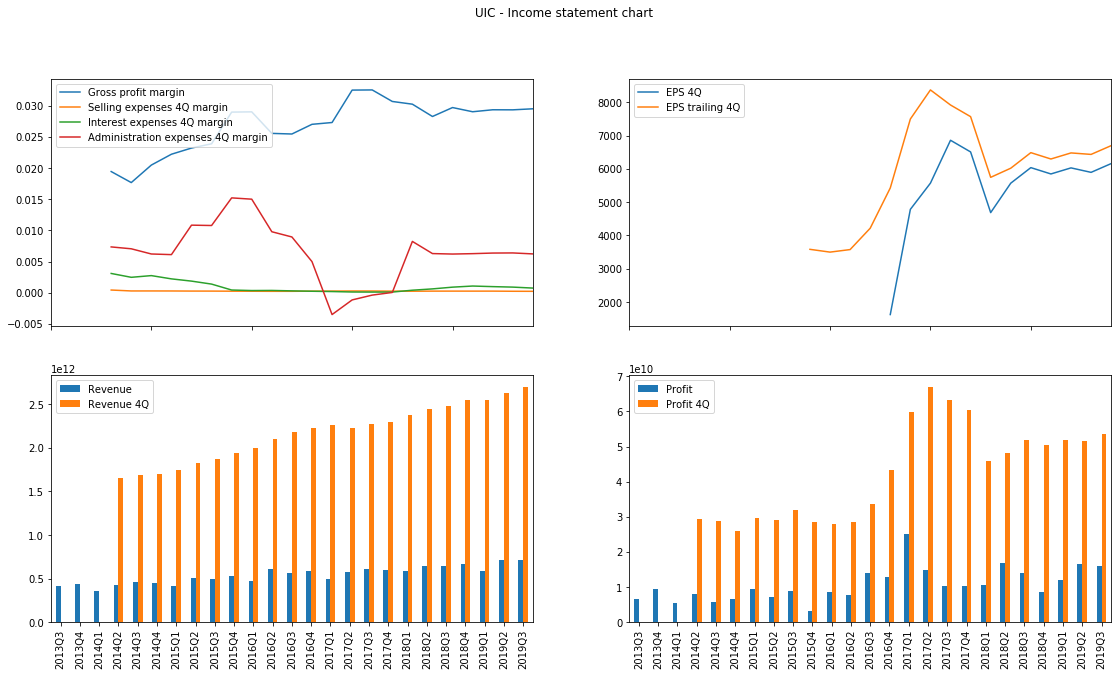

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

df = df_balance[df_balance['Item']=='Lãi cơ bản trên cổ phiếu'].transpose()[1:].sort_index(ascending=True)
df.columns = ['EPS']
df['EPS 4Q'] = df['EPS'].rolling(4).sum()
df['Revenue'] = df_balance[df_balance['Item']=='Doanh thu thuần'].transpose()[1:]
df['Revenue 4Q'] = df['Revenue'].rolling(4).sum()
df['Gross profit'] = df_balance[df_balance['Item']=='Lợi nhuận gộp'].transpose()[1:]
df['Gross profit 4Q'] = df['Gross profit'].rolling(4).sum()
df['Gross profit margin'] = df['Gross profit 4Q'].divide(df['Revenue 4Q'])
df['Profit'] = df_balance[df_balance['Item']=='Lợi nhuận sau thuế của Công ty mẹ'].transpose()[1:]
df['Profit 4Q'] = df['Profit'].rolling(4).sum()
df['Total Assets'] = df_balance[df_balance['Item']=='TỔNG CỘNG TÀI SẢN'].transpose()[1:]
df['Equity'] = df_balance[df_balance['Item']=='Cổ phiếu phổ thông'].transpose()[1:].replace(0, np.nan)
df['EPS trailing'] = 10000 * df['Profit'].divide(df['Equity'])
df['EPS trailing 4Q'] = df['EPS trailing'].rolling(4).sum()

df['Selling expenses'] = df_balance[df_balance['Item']=='Chi phí bán hàng'].transpose()[1:]
df['Selling expenses 4Q'] = df['Selling expenses'].rolling(4).sum()
df['Selling expenses 4Q margin'] = df['Selling expenses 4Q'].divide(df['Revenue 4Q'])
df['Interest expenses'] = df_balance[df_balance['Item']=='Trong đó: Chi phí lãi vay'].transpose()[1:]
df['Interest expenses 4Q'] = df['Interest expenses'].rolling(4).sum()
df['Interest expenses 4Q margin'] = df['Interest expenses 4Q'].divide(df['Revenue 4Q'])
df['Administration expenses'] = df_balance[df_balance['Item']=='Chi phí quản lý doanh nghiệp'].transpose()[1:]
df['Administration expenses 4Q'] = df['Administration expenses'].rolling(4).sum()
df['Administration expenses 4Q margin'] = df['Administration expenses 4Q'].divide(df['Revenue 4Q'])

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(19, 10))
plt.suptitle(symbol + " - Income statement chart")

df[['Gross profit margin','Selling expenses 4Q margin','Interest expenses 4Q margin','Administration expenses 4Q margin']].plot.line(ax=axes[0,0],sharex = True).legend(loc=2)
df[['EPS 4Q','EPS trailing 4Q']].plot.line(ax=axes[0,1],sharex = True).legend(loc=2)

df[['Revenue','Revenue 4Q']].plot.bar(ax=axes[1,0]).legend(loc=2)
df[['Profit','Profit 4Q']].plot.bar(ax=axes[1,1]).legend(loc=2)




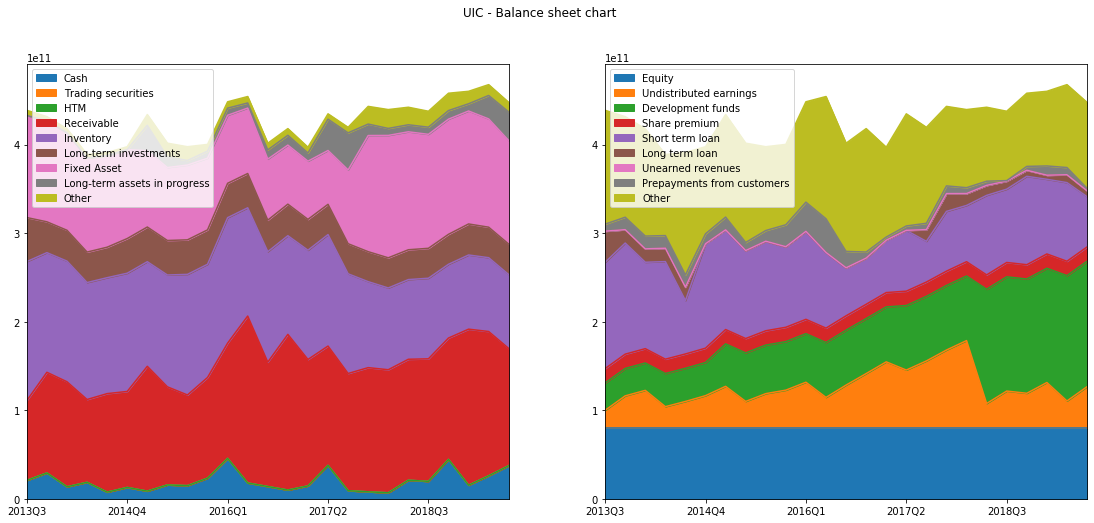

In [24]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(19, 8), sharex=True)
plt.suptitle(symbol + " - Balance sheet chart")

dfAssets = df_balance[df_balance['Item']=='TỔNG CỘNG TÀI SẢN'].transpose()[1:].sort_index(ascending=True)
dfAssets.columns = ['Total Assets']
dfAssets['Cash'] = df_balance[df_balance['Item']=='Tiền và các khoản tương đương tiền'].transpose()[1:]
dfAssets['Trading securities'] = df_balance[df_balance['Item']=='Đầu tư ngắn hạn'].transpose()[1:] 
dfAssets['HTM'] = df_balance[df_balance['Item']=='Đầu tư giữ đến ngày đáo hạn'].transpose()[1:]
dfAssets['Receivable'] = df_balance[df_balance['Item']=='Các khoản phải thu ngắn hạn'].transpose()[1:]
dfAssets['Inventory'] = df_balance[df_balance['Item']=='Hàng tồn kho'].transpose()[1:].iloc[:, [0]]
dfAssets['Long-term investments'] = df_balance[df_balance['Item']=='Các khoản đầu tư tài chính dài hạn'].transpose()[1:]
dfAssets['Fixed Asset'] = df_balance[df_balance['Item']=='Tài sản cố định'].transpose()[1:]
dfAssets['Long-term assets in progress'] = df_balance[df_balance['Item']=='Tài sản dở dang dài hạn'].transpose()[1:]

dfAssets['Other'] = dfAssets['Total Assets']
for i in range(1,len(dfAssets.columns)-1):
  dfAssets['Other'] = dfAssets['Other'] - dfAssets.iloc[:,i].fillna(0)
dfAssets.drop(['Total Assets'], axis=1, inplace=True)
dfAssets.plot.area(ax=axes[0]).legend(loc=2)

dfLiabilities = df_balance[df_balance['Item']=='TỔNG CỘNG TÀI SẢN'].transpose()[1:].sort_index(ascending=True)
dfLiabilities.columns = ['Total Asset']

dfLiabilities['Equity'] = df_balance[df_balance['Item']=='Vốn góp'].transpose()[1:]
dfLiabilities['Undistributed earnings'] = df_balance[df_balance['Item']=='Lợi nhuận sau thuế chưa phân phối'].transpose()[1:]
dfLiabilities.loc[dfLiabilities['Undistributed earnings'] < 0, 'Undistributed earnings'] = 0
dfLiabilities['Development funds'] = df_balance[df_balance['Item']=='Quỹ đầu tư phát triển'].transpose()[1:]
dfLiabilities['Share premium'] = df_balance[df_balance['Item']=='Thặng dư vốn cổ phần'].transpose()[1:]
dfLiabilities.loc[dfLiabilities['Share premium'] < 0, 'Share premium'] = 0
dfLiabilities['Short term loan'] = df_balance[df_balance['Item']=='Vay và nợ ngắn hạn'].transpose()[1:]
dfLiabilities['Long term loan'] = df_balance[df_balance['Item']=='Vay và nợ dài hạn'].transpose()[1:]
dfLiabilities['Unearned revenues'] = df_balance[df_balance['Item']=='Doanh thu chưa thực hiện ngắn hạn'].transpose()[1:].add(df_balance[df_balance['Item']=='Doanh thu chưa thực hiện dài hạn'].transpose()[1:].values)
dfLiabilities['Prepayments from customers'] = df_balance[df_balance['Item']=='Người mua trả tiền trước'].transpose()[1:]

dfLiabilities.loc[dfLiabilities['Unearned revenues'] < 0, 'Unearned revenues'] = 0
dfLiabilities['Other'] = dfLiabilities['Total Asset']
dfLiabilities = dfLiabilities.fillna(0)

for i in range(1,len(dfLiabilities.columns)-1):
  dfLiabilities['Other'] = dfLiabilities['Other'] - dfLiabilities.iloc[:,i].fillna(0)
dfLiabilities.drop(['Total Asset'], axis=1, inplace=True)

dfLiabilities.plot.area(ax=axes[1]).legend(loc=2)



In [0]:
def getCashFlow(symbol, quater ='IN_YEAR', year = '2019'):
  files = {'searchObject.fiscalQuarter': quater,'searchObject.fiscalYear': year,'searchObject.numberTerm':'5','searchObject.moneyRate': '1'}
  req = requests.post('https://www.vndirect.com.vn/portal/bao-cao-luu-chuyen-tien-te/' + symbol + '.shtml',files)

  soup = BeautifulSoup(req.text, "lxml")

  period = []
  tmp = soup.form.tr.tr.find_all('td')
  for i in range(1,len(tmp)):
    tmpStr = tmp[i].b.string.strip()
    if (tmpStr != ''):    
      # Add period when have item value 
      if quater == 'IN_YEAR':
        period.append(tmpStr)
      else:
        period.append(tmpStr[3:7] + tmpStr[0:2])
  # Value list
  tmp = soup.form.tr.find_all('tr')
  val2 = []
  for i in range(1,len(tmp)):
    val = []
    for j in range(0,len(period)+1):
      tmpStr = tmp[i].find_all('div')[j].string
      if (str(tmpStr) == 'None'):
        if tmp[i].find_all('div')[j].find('img'):
          tmpStr = tmp[i].find_all('div')[j].img.next_sibling
        else:
          tmpStr = tmp[i].find_all('div')[j].em.contents[0]
      if (j==0):
        val.append(tmpStr.string.replace('\n','').replace('\xa0','').strip())
      else:
        intStr = tmpStr.string.replace('\n','').replace('\xa0','').replace(',','').strip()
        if (intStr != ''):
          val.append(int(intStr))
        else:
          val.append(0)
    val2.append(val)
  if len(val2) == 0:
    df = pd.DataFrame()
  else:
    df = pd.DataFrame(val2)
    df.columns = ['Item'] + period[0:len(df.columns)-1]
  return df


#Merger voi bao cao quy moi nhat

df = getCashFlow(symbol,'Q4',year[0])
cols = [col for col in df.columns if '2019' in col]

df['Total'] = df[cols].sum(axis=1)
curPeriod = df.columns[1]

df = df[['Item','Total']]
df.columns = ['Item',curPeriod]

df_cashflow = pd.merge(getCashFlow(symbol,'IN_YEAR',year[0]), df, how='left', on=['Item'], left_index = True, right_index= True)



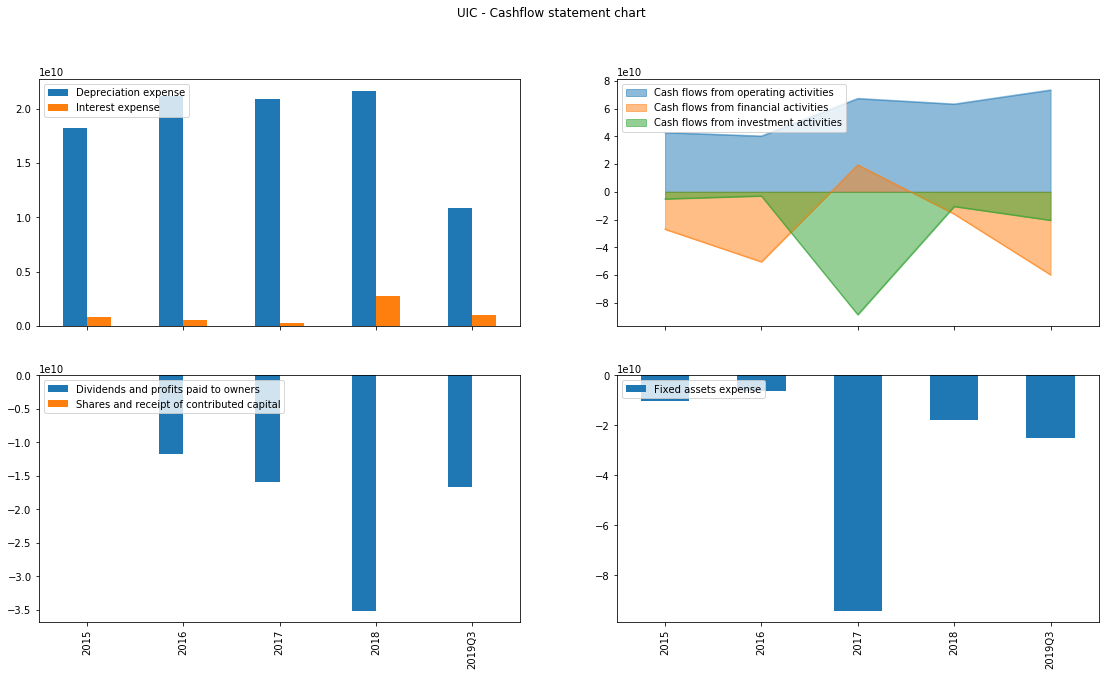

In [26]:

dfCashflow = df_cashflow[df_cashflow['Item']=='Chi phí khấu hao tài sản cố định'].transpose()[1:].sort_index(ascending=True)
dfCashflow.columns = ['Depreciation expense']
dfCashflow['Interest expense'] = df_cashflow[df_cashflow['Item']=='Chi phí lãi vay'].transpose()[1:].add(-1 * df_cashflow[df_cashflow['Item']=='Tiền chi trả lãi vay'].transpose()[1:].values)

dfCashflow['Cash flows from operating activities'] = df_cashflow[df_cashflow['Item']=='Lưu chuyển tiền thuần từ hoạt động kinh doanh'].transpose()[1:]
dfCashflow['Cash flows from financial activities'] = df_cashflow[df_cashflow['Item']=='Lưu chuyển tiền thuần từ hoạt động tài chính'].transpose()[1:]
dfCashflow['Cash flows from investment activities'] = df_cashflow[df_cashflow['Item']=='Lưu chuyển tiền thuần từ hoạt động đầu tư'].transpose()[1:]

dfCashflow['Dividends and profits paid to owners'] = df_cashflow[df_cashflow['Item']=='Cổ tức, lợi nhuận đã trả cho chủ sở hữu'].transpose()[1:]
dfCashflow['Shares and receipt of contributed capital'] = df_cashflow[df_cashflow['Item']=='Tiền thu từ phát hành cổ phiếu, nhận vốn góp của chủ sở hữu'].transpose()[1:]

dfCashflow['Fixed assets expense'] = df_cashflow[df_cashflow['Item']=='Mua sắm TSCĐ'].transpose()[1:]

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(19, 10), sharex=True)

plt.suptitle(symbol + " - Cashflow statement chart")

dfCashflow[['Depreciation expense','Interest expense']].plot.bar(ax=axes[0,0]).legend(loc=2)
dfCashflow[['Cash flows from operating activities','Cash flows from financial activities','Cash flows from investment activities']].plot.area(ax=axes[0,1], stacked = False ).legend(loc=2)
dfCashflow[['Dividends and profits paid to owners','Shares and receipt of contributed capital']].plot.bar(ax=axes[1,0]).legend(loc=2)

dfCashflow[['Fixed assets expense']].plot.bar(ax=axes[1,1]).legend(loc=2)

In [27]:
dfCashflow

,Depreciation expense,Interest expense,Cash flows from operating activities,Cash flows from financial activities,Cash flows from investment activities,Dividends and profits paid to owners,Shares and receipt of contributed capital,Fixed assets expense
2015,18212735963,844832963,42714058603,-27017136700,-5192552802,0,0,-10381952065
2016,21183088754,531700284,40160003172,-50547166375,-3036764596,-11760856975,0,-6362463262
2017,20888787159,245630778,67257903161,19406199700,-88659782209,-15993800300,0,-94139915845
2018,21649268323,2733392645,63245801328,-16050273485,-10610306785,-35150273485,0,-17742420309
2019Q3,10844329728,979604930,73403493742,-59885171315,-20564738269,-16747795315,0,-25216066199


In [28]:
dfLiabilities

,Equity,Undistributed earnings,Development funds,Share premium,Short term loan,Long term loan,Unearned revenues,Prepayments from customers,Other
2013Q3,8.000000e+10,1.996794e+10,3.090687e+10,1.620000e+10,1.200012e+11,3.500000e+10,137733131.0,7.932576e+09,1.285437e+11
2013Q4,8.000000e+10,3.624441e+10,3.090687e+10,1.620000e+10,1.254531e+11,1.500000e+10,119733131.0,1.405136e+10,1.135803e+11
2014Q1,8.000000e+10,4.245277e+10,3.090687e+10,1.620000e+10,9.755730e+10,1.500000e+10,101733131.0,1.446557e+10,1.211491e+11
2014Q2,8.000000e+10,2.404522e+10,3.742682e+10,1.620000e+10,1.101818e+11,1.500000e+10,155733131.0,1.424195e+10,9.154993e+10
2014Q3,8.000000e+10,2.993238e+10,3.742682e+10,1.620000e+10,6.026943e+10,1.500000e+10,137733131.0,1.380399e+10,1.382396e+11
2014Q4,8.000000e+10,3.648504e+10,3.742682e+10,1.620000e+10,1.178034e+11,0.000000e+00,119733131.0,1.117933e+10,9.840002e+10
2015Q1,8.000000e+10,4.700906e+10,4.793606e+10,1.620000e+10,1.124880e+11,0.000000e+00,101733131.0,1.438235e+10,1.158161e+11
2015Q2,8.000000e+10,2.996637e+10,5.481055e+10,1.620000e+10,9.920698e+10,0.000000e+00,155733131.0,9.130647e+09,1.121264e+11
2015Q3,8.000000e+10,3.876023e+10,5.481055e+10,1.620000e+10,1.008928e+11,0.000000e+00,204144429.0,1.208407e+10,9.463973e+10
2015Q4,8.000000e+10,4.269976e+10,5.481055e+10,1.620000e+10,9.078631e+10,0.000000e+00,185048484.0,2.476263e+10,9.077590e+10
